# Determining optimal number of topics using Coherence Score

Determining the optimal number of topics (num_topics) in LDA topic modeling is crucial for extracting meaningful insights. We can use coherence score to find the best number of topics. The coherence score measures the quality of topics by evaluating the semantic similarity of the top words in each topic. The higher the coherence score, the better the topics.

Note:
In topic modeling using Latent Dirichlet Allocation (LDA), the coherence score is a metric used to evaluate how semantically similar the words within a topic are to each other, essentially measuring how interpretable and meaningful a given topic is to humans; a higher coherence score indicates that the words within a topic are closely related and make sense together, while a lower score suggests a less coherent, unclear topic. 

Num Topics: 2, Coherence Score: 0.2135
Num Topics: 4, Coherence Score: 0.2328
Num Topics: 6, Coherence Score: 0.3079
Num Topics: 8, Coherence Score: 0.3171
Num Topics: 10, Coherence Score: 0.2910
Num Topics: 12, Coherence Score: 0.2793
Num Topics: 14, Coherence Score: 0.2821


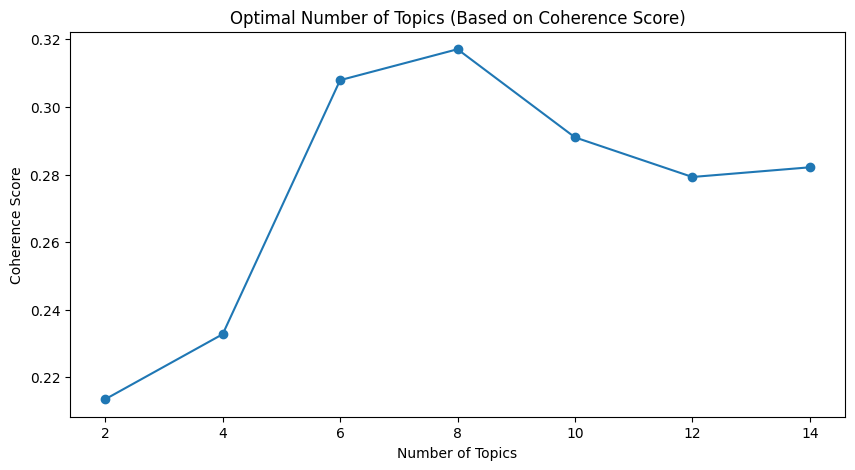

In [ ]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Step 1: Load the dataset
df = pd.read_csv("../datasets/news_dataset_headlines_cleaned.csv")  # Replace with actual file path

# Step 2: Ensure `headline_words` is a list of tokenized words
df['headline_words'] = df['headline_words'].apply(eval)  # Convert string to list if needed

# Step 3: Define Stopwords List (Expanded)
custom_stopwords = set([
    "said", "one", "new", "people", "like", "time", "year", "just", "know", "think", "make", "get", "also",
    "many", "day", "week", "month", "even", "still", "back", "see", "way", "want", "need", "thing", "go",
    "use", "give", "first", "two", "three", "take", "since", "well", "much", "could", "should", "would", 
    "question", "statement", "really", "going", "u", "best", "lot", "far", "added", "got", "may",
    "according", "might", "whether", "say", "look", "always", "let", "yet", "asked", "across", "never",
    "di", "mean",

    "cbc.ca", "cbc_news", "cbc_sports", "breitbart", "daily_caller",
    "the_federalist", "washington_examiner", "daily_kos", "the_daily_beast",
    "national_review", "axios", "propublica", "the_new_yorker", "the_atlantic",
    "newsweek", "time", "financial_times", "the_economist", "economist_impact",
    "cnbc", "huffpost", "newsmax", "the_guardian", "the_guardian_us",
    "pbs_newshour", "al_jazeera_english", "bloomberg", "reuters_uk", "reuters",
    "reuters.com", "forbes", "new_york_post", "politico", "the_associated_press",
    "the_wall_street_journal", "usa_today", "reviewed", "bbc.com",
    "the_washington_post", "washington_post", "img.washingtonpost.com",
    "the_new_york_times", "abc_news", "cbs_minnesota", "cbs_news",
    "cbs_san_francisco", "cbs_miami", "cbs_pittsburgh", "cbs_boston",
    "cbs_chicago", "cbs_los_angeles", "cbs_new_york", "cbs_baltimore",
    "cbs_colardo", "fox_news", "cnn", "cnn_underscored", "cnn_press_room",
    "national_post", "the_globe_and_mail", "global_news_toronto",
    "global_news_lethbridge", "global_news_london", "global_news",
    "global_news_kingston", "global_news_edmonton", "global_news_hamilton",
    "global_news_bc", "global_news_calgary", "global_news_peterborough",
    "global_news_guelph", "global_news_regina", "global_news_halifax",
    "global_news_okanagan", "global_news_montréal", "global_news_ottawa",
    "global_news_saskatoon", "global_news_winnipeg", "global_news_barrie",
    "toronto_sun", "guardian", "c-span", "reuters_india", "reuters_canada", "usa_today",
    "golfweek", "www-staging.washingtonpost.com", "cbs_philly", "fox_news_radio",
    "cnn_international", "pew_research_center", "realclearpolitics", "new_york_time", 
    "associated_press", "globe_mail",

    'CBC.ca', 'CBC News', 'CBC Sports', 'Breitbart', 'Daily Caller',
    'The Federalist', 'Washington Examiner', 'Daily Kos', 'The Daily Beast',
    'National Review', 'Axios', 'ProPublica', 'The New Yorker', 'The Atlantic',
    'Newsweek', 'TIME', 'Financial Times', 'The Economist', 'Economist Impact',
    'CNBC', 'HuffPost', 'Newsmax', 'The Guardian', 'The Guardian US',
    'PBS NewsHour', 'Al Jazeera English', 'Bloomberg', 'Reuters UK', 'Reuters',
    'Reuters.com', 'Forbes', 'New York Post', 'POLITICO', 'The Associated Press',
    'The Wall Street Journal', 'USA TODAY', 'Reviewed', 'BBC.com',
    'The Washington Post', 'Washington Post', 'img.washingtonpost.com',
    'The New York Times', 'ABC News', 'CBS Minnesota', 'CBS News',
    'CBS San Francisco', 'CBS Miami', 'CBS Pittsburgh', 'CBS Boston',
    'CBS Chicago', 'CBS Los Angeles', 'CBS New York', 'CBS Baltimore',
    'CBS Colardo', 'Fox News', 'CNN', 'CNN Underscored', 'CNN Press Room',
    'National Post', 'The Globe and Mail', 'Global News Toronto',
    'Global News Lethbridge', 'Global News London', 'Global News',
    'Global News Kingston', 'Global News Edmonton', 'Global News Hamilton',
    'Global News BC', 'Global News Calgary', 'Global News Peterborough',
    'Global News Guelph', 'Global News Regina', 'Global News Halifax',
    'Global News Okanagan', 'Global News Montréal', 'Global News Ottawa',
    'Global News Saskatoon', 'Global News Winnipeg', 'Global News Barrie',
    'Toronto Sun', 'C-SPAN', 'Reuters India', 'Reuters Canada', 'USA Today',
    'Golfweek', 'www-staging.washingtonpost.com', 'CBS Philly', 'FOX News Radio',
    'CNN International', 'Pew Research Center', 'RealClearPolitics',

])

# Remove Stopwords from Tokenized Headlines
df['headline_words'] = df['headline_words'].apply(lambda x: [word for word in x if word not in custom_stopwords])

# Step 4: Create Dictionary and Corpus
dictionary = corpora.Dictionary(df['headline_words'])
dictionary.filter_extremes(no_below=10, no_above=0.4, keep_n=10000)  # Reduce noise
corpus = [dictionary.doc2bow(text) for text in df['headline_words']]

# Step 5: Define a range of topic numbers to test
topic_range = range(2, 15, 2)  # Test even numbers between 2 and 14
coherence_scores = []

# Step 6: Train LDA models with different `num_topics` and calculate coherence
for num_topics in topic_range:
    lda_model = gensim.models.LdaMulticore(
        corpus, num_topics=num_topics, id2word=dictionary, passes=5, workers=4, random_state=42
    )
    
    coherence_model = CoherenceModel(model=lda_model, texts=df['headline_words'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    
    print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

# Step 7: Plot Coherence Score vs Number of Topics
plt.figure(figsize=(10, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics (Based on Coherence Score)")
plt.show()

# WordCloud and Bar Chart as the Visualization of the Topic Modelling Result

LDA Coherence Score: 0.3677
LDA Perplexity Score: -7.8781
Topic 0: 0.021*"trump" + 0.015*"state" + 0.015*"case" + 0.014*"police" + 0.012*"man" + 0.011*"court" + 0.011*"supreme_court" + 0.010*"judge" + 0.009*"shooting" + 0.009*"page_new_york"

Topic 1: 0.019*"woman" + 0.009*"right" + 0.008*"life" + 0.008*"review" + 0.008*"olympic" + 0.007*"game" + 0.006*"men" + 0.006*"star" + 0.006*"opinion" + 0.006*"american"

Topic 2: 0.065*"trump" + 0.060*"biden" + 0.026*"harris" + 0.020*"kamala_harris" + 0.016*"campaign" + 0.016*"democrat" + 0.013*"opinion" + 0.013*"debate" + 0.013*"republican" + 0.010*"donald_trump"

Topic 3: 0.039*"trump" + 0.019*"trial" + 0.014*"school" + 0.011*"speech" + 0.010*"watch" + 0.010*"rnc" + 0.009*"student" + 0.008*"dnc" + 0.008*"book" + 0.007*"hush_money"

Topic 4: 0.044*"financial" + 0.037*"election" + 0.022*"uk" + 0.021*"labour" + 0.011*"politics" + 0.011*"party" + 0.010*"government" + 0.010*"tory" + 0.010*"face" + 0.010*"next"

Topic 5: 0.012*"million" + 0.009*"pay"

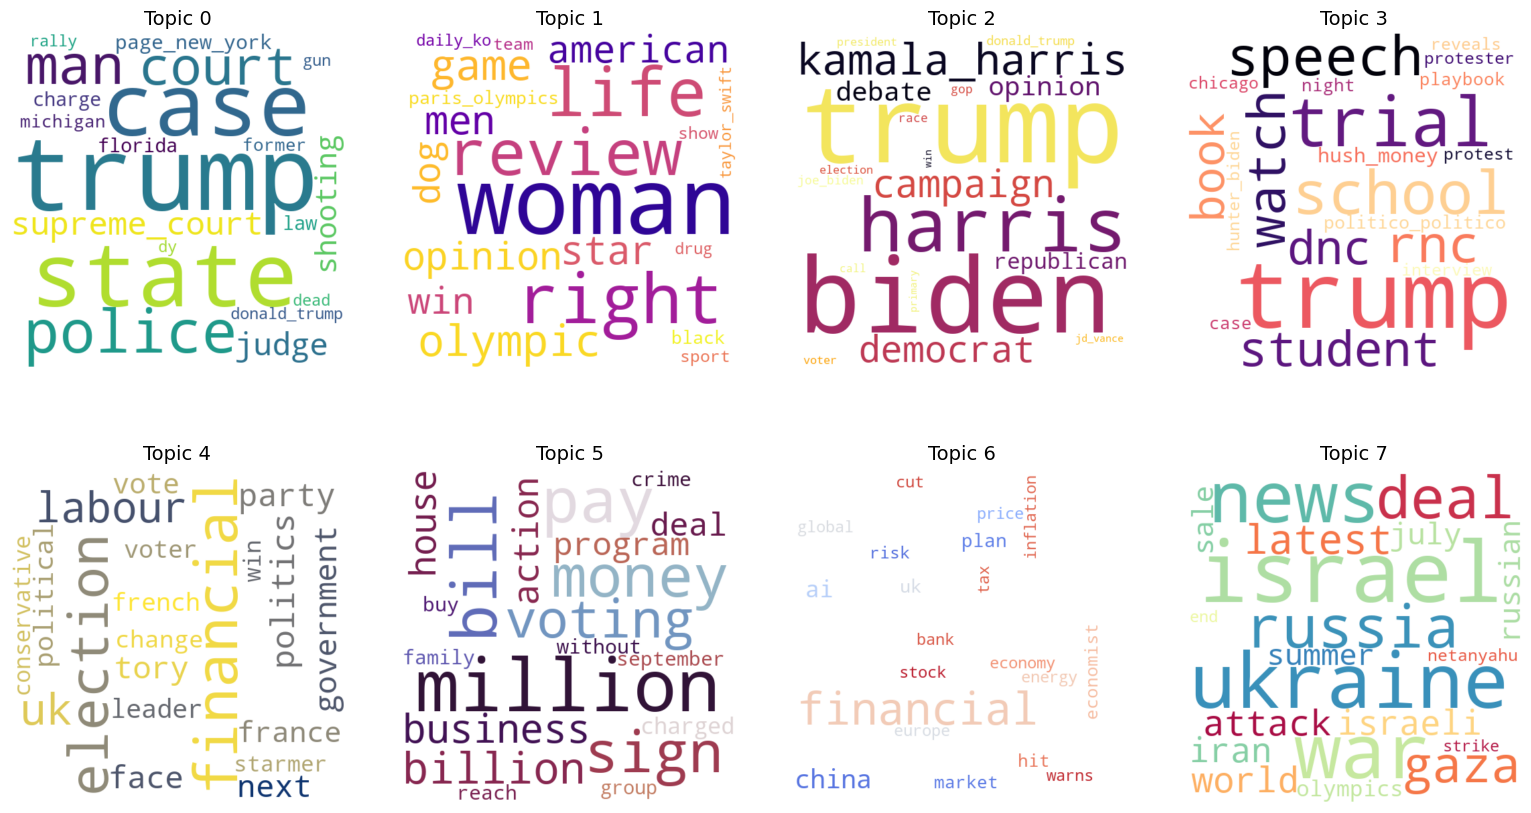

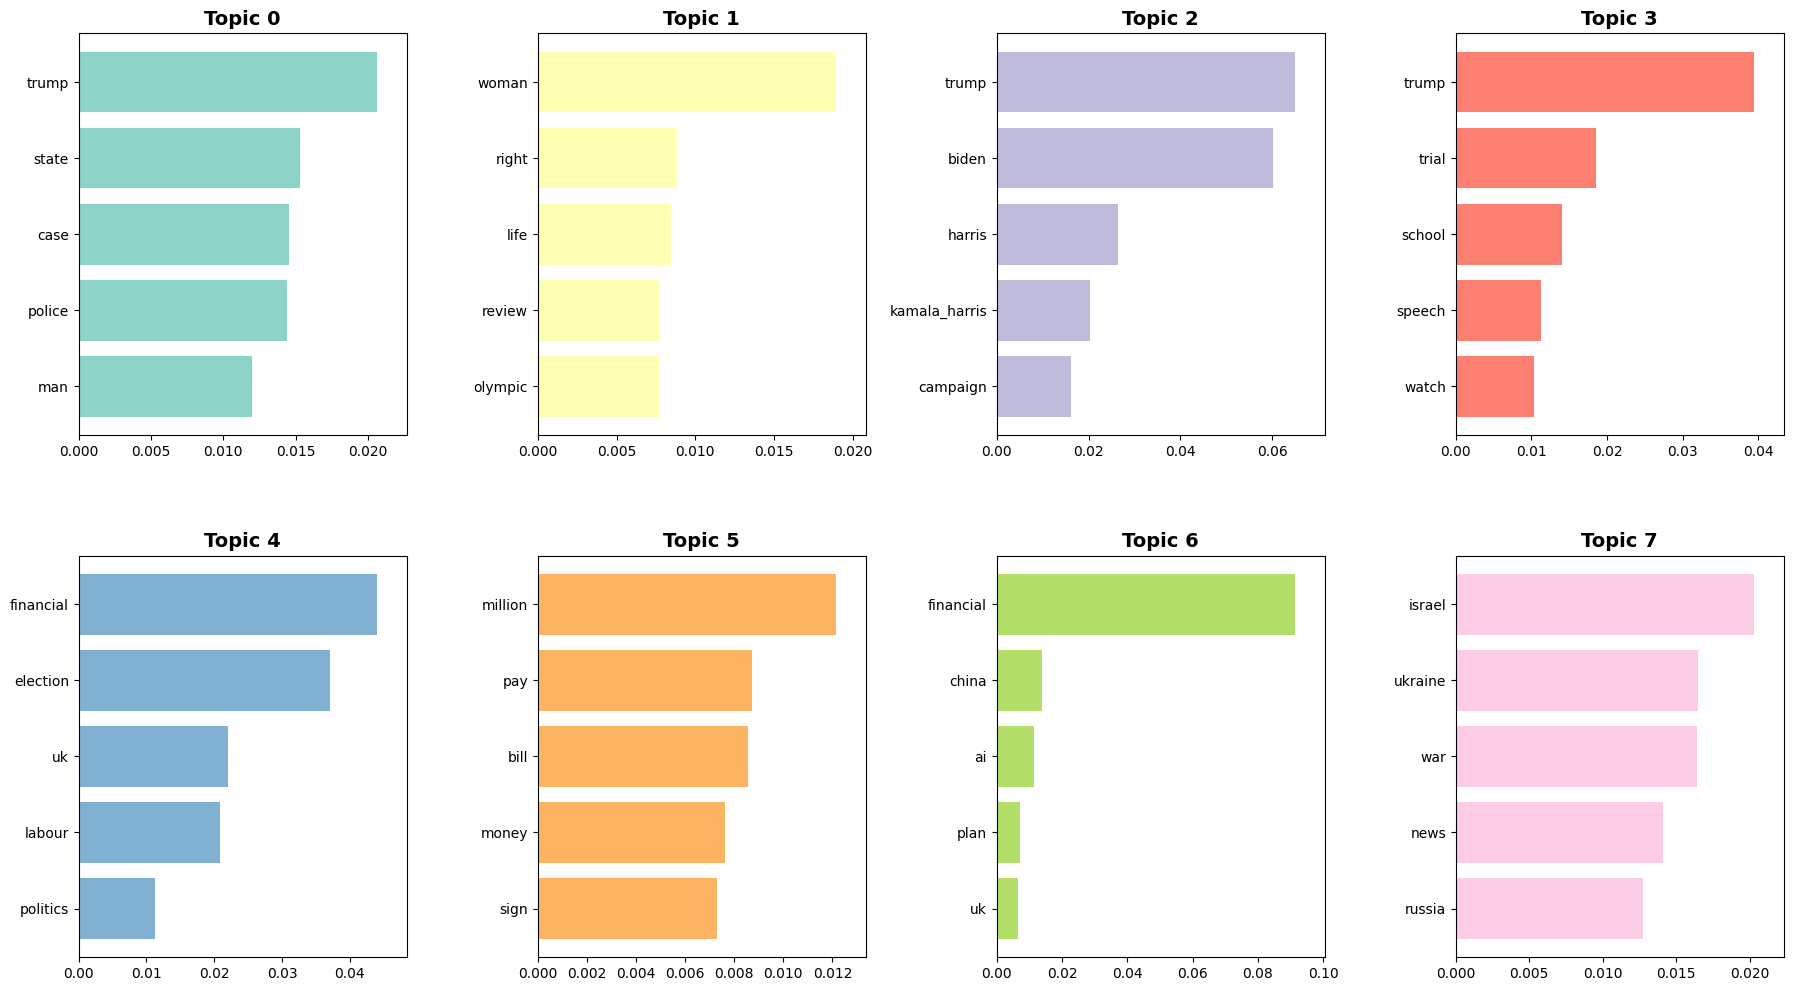

In [ ]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaMulticore
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import multiprocessing
from gensim.models.phrases import Phrases, Phraser
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import seaborn as sns

# Load dataset (update with your actual file path)
df = pd.read_csv("../datasets/news_dataset_headlines_cleaned.csv")  

# Convert content_words column (assumed to be list-like) into a list of tokenized words
df['headline_words'] = df['headline_words'].apply(eval)  # Ensure the column is in list format

# 1. Detect Bigrams and Trigrams with Higher Threshold
bigram = Phrases(df['headline_words'], min_count=10, threshold=30)  
trigram = Phrases(bigram[df['headline_words']], min_count=10, threshold=30)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Apply bigrams and trigrams
df['headline_words'] = df['headline_words'].apply(lambda x: trigram_mod[bigram_mod[x]])

# 2. Remove Low-Information Words (Expanded Stopwords List)
custom_stopwords = set([
    "said", "one", "new", "people", "like", "time", "year", "just", "know", "think", "make", "get", "also",
    "many", "day", "week", "month", "even", "still", "back", "see", "way", "want", "need", "thing", "go",
    "use", "give", "first", "two", "three", "take", "since", "well", "much", "could", "should", "would", 
    "question", "statement", "really", "going", "u", "best", "lot", "far", "added", "got", "may",
    "according", "might", "whether", "say", "look", "always", "let", "yet", "asked", "across", "never",
    "di", "mean",

    "cbc.ca", "cbc_news", "cbc_sports", "breitbart", "daily_caller",
    "the_federalist", "washington_examiner", "daily_kos", "the_daily_beast",
    "national_review", "axios", "propublica", "the_new_yorker", "the_atlantic",
    "newsweek", "time", "financial_times", "the_economist", "economist_impact",
    "cnbc", "huffpost", "newsmax", "the_guardian", "the_guardian_us",
    "pbs_newshour", "al_jazeera_english", "bloomberg", "reuters_uk", "reuters",
    "reuters.com", "forbes", "new_york_post", "politico", "the_associated_press",
    "the_wall_street_journal", "usa_today", "reviewed", "bbc.com",
    "the_washington_post", "washington_post", "img.washingtonpost.com",
    "the_new_york_times", "abc_news", "cbs_minnesota", "cbs_news",
    "cbs_san_francisco", "cbs_miami", "cbs_pittsburgh", "cbs_boston",
    "cbs_chicago", "cbs_los_angeles", "cbs_new_york", "cbs_baltimore",
    "cbs_colardo", "fox_news", "cnn", "cnn_underscored", "cnn_press_room",
    "national_post", "the_globe_and_mail", "global_news_toronto",
    "global_news_lethbridge", "global_news_london", "global_news",
    "global_news_kingston", "global_news_edmonton", "global_news_hamilton",
    "global_news_bc", "global_news_calgary", "global_news_peterborough",
    "global_news_guelph", "global_news_regina", "global_news_halifax",
    "global_news_okanagan", "global_news_montréal", "global_news_ottawa",
    "global_news_saskatoon", "global_news_winnipeg", "global_news_barrie",
    "toronto_sun", "guardian", "c-span", "reuters_india", "reuters_canada", "usa_today",
    "golfweek", "www-staging.washingtonpost.com", "cbs_philly", "fox_news_radio",
    "cnn_international", "pew_research_center", "realclearpolitics", "new_york_time", 
    "associated_press", "globe_mail",

    'CBC.ca', 'CBC News', 'CBC Sports', 'Breitbart', 'Daily Caller',
    'The Federalist', 'Washington Examiner', 'Daily Kos', 'The Daily Beast',
    'National Review', 'Axios', 'ProPublica', 'The New Yorker', 'The Atlantic',
    'Newsweek', 'TIME', 'Financial Times', 'The Economist', 'Economist Impact',
    'CNBC', 'HuffPost', 'Newsmax', 'The Guardian', 'The Guardian US',
    'PBS NewsHour', 'Al Jazeera English', 'Bloomberg', 'Reuters UK', 'Reuters',
    'Reuters.com', 'Forbes', 'New York Post', 'POLITICO', 'The Associated Press',
    'The Wall Street Journal', 'USA TODAY', 'Reviewed', 'BBC.com',
    'The Washington Post', 'Washington Post', 'img.washingtonpost.com',
    'The New York Times', 'ABC News', 'CBS Minnesota', 'CBS News',
    'CBS San Francisco', 'CBS Miami', 'CBS Pittsburgh', 'CBS Boston',
    'CBS Chicago', 'CBS Los Angeles', 'CBS New York', 'CBS Baltimore',
    'CBS Colardo', 'Fox News', 'CNN', 'CNN Underscored', 'CNN Press Room',
    'National Post', 'The Globe and Mail', 'Global News Toronto',
    'Global News Lethbridge', 'Global News London', 'Global News',
    'Global News Kingston', 'Global News Edmonton', 'Global News Hamilton',
    'Global News BC', 'Global News Calgary', 'Global News Peterborough',
    'Global News Guelph', 'Global News Regina', 'Global News Halifax',
    'Global News Okanagan', 'Global News Montréal', 'Global News Ottawa',
    'Global News Saskatoon', 'Global News Winnipeg', 'Global News Barrie',
    'Toronto Sun', 'C-SPAN', 'Reuters India', 'Reuters Canada', 'USA Today',
    'Golfweek', 'www-staging.washingtonpost.com', 'CBS Philly', 'FOX News Radio',
    'CNN International', 'Pew Research Center', 'RealClearPolitics',

])
df['headline_words'] = df['headline_words'].apply(lambda x: [word for word in x if word not in custom_stopwords])

# 3. Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['headline_words'])

# 4. Filter out extreme tokens (Higher no_below to remove rare words)
dictionary.filter_extremes(no_below=10, no_above=0.3, keep_n=10000)  

# 5. Convert to Bag-of-Words format
corpus = [dictionary.doc2bow(text) for text in df['headline_words']]

# 6. Train LDA Model Using MULTICORE Processing
num_topics = 8
lda_model = LdaMulticore(
    corpus=corpus, 
    num_topics=num_topics, 
    id2word=dictionary, 
    passes=100,  
    workers=multiprocessing.cpu_count(),  
    random_state=42
)

# 7. Compute LDA Coherence Score
coherence_model = CoherenceModel(model=lda_model, texts=df['headline_words'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# 8. Compute LDA Perplexity Score
perplexity_score = lda_model.log_perplexity(corpus)

# Print Evaluation Metrics
print(f"LDA Coherence Score: {coherence_score:.4f}")  # Higher is better
print(f"LDA Perplexity Score: {perplexity_score:.4f}")  # Lower is better

# 9. Print the top words in each topic
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}\n")

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 10. Visualize topics using WordClouds
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))  # Reduce width a bit
axes = axes.flatten()
wordcloud_colors = ["viridis", "plasma", "inferno", "magma", "cividis", "twilight", "coolwarm", "Spectral"]

for i in range(num_topics):
    topic_words = dict(lda_model.show_topic(i, 20))
    wordcloud = WordCloud(width=500, height=500, background_color='white', colormap=wordcloud_colors[i]).generate_from_frequencies(topic_words)
    
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Topic {i}", fontsize=14)

# Fine-tune white space
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # Reduce wspace more to remove wide gaps
plt.show()

# 12. Generate Bar Chart for Top 5 Words in Each Topic
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(22, 12))  # Increase height
axes = axes.flatten()
distinct_colors = sns.color_palette("Set3", num_topics)

for i in range(num_topics):
    topic_words = dict(lda_model.show_topic(i, 5))
    words = list(topic_words.keys())
    values = list(topic_words.values())
    
    axes[i].barh(words, values, color=distinct_colors[i])
    axes[i].invert_yaxis()
    axes[i].set_title(f"Topic {i}", fontsize=14, fontweight='bold')
    axes[i].set_xlim(0, max(values) * 1.1)  # Adjust x-axis for better spacing

# Adjust spacing to make bar charts less squeezed
plt.subplots_adjust(hspace=0.3, wspace=0.4)  
plt.show()

This code analyzes how different news outlets cover various topics using a trained LDA model. It first extracts topic probabilities for each document and aggregates them by news source. The top 10 news sources are selected based on their total topic probability, ensuring that the most influential outlets are analyzed. The topic distributions are then normalized for fair comparison. The results are visualized using:

Stacked Bar Chart – Shows the proportion of topics across the top 10 news sources.
Heatmap – Highlights topic intensity for each news outlet, with a light-to-dark red gradient indicating lower to higher topic presence.
These visualizations help identify how different media sources emphasize various topics.

# Top 10 News Sources based on Topic Probability Distribution (Analyzing which outlets contribute most to topics)

<Figure size 1400x800 with 0 Axes>

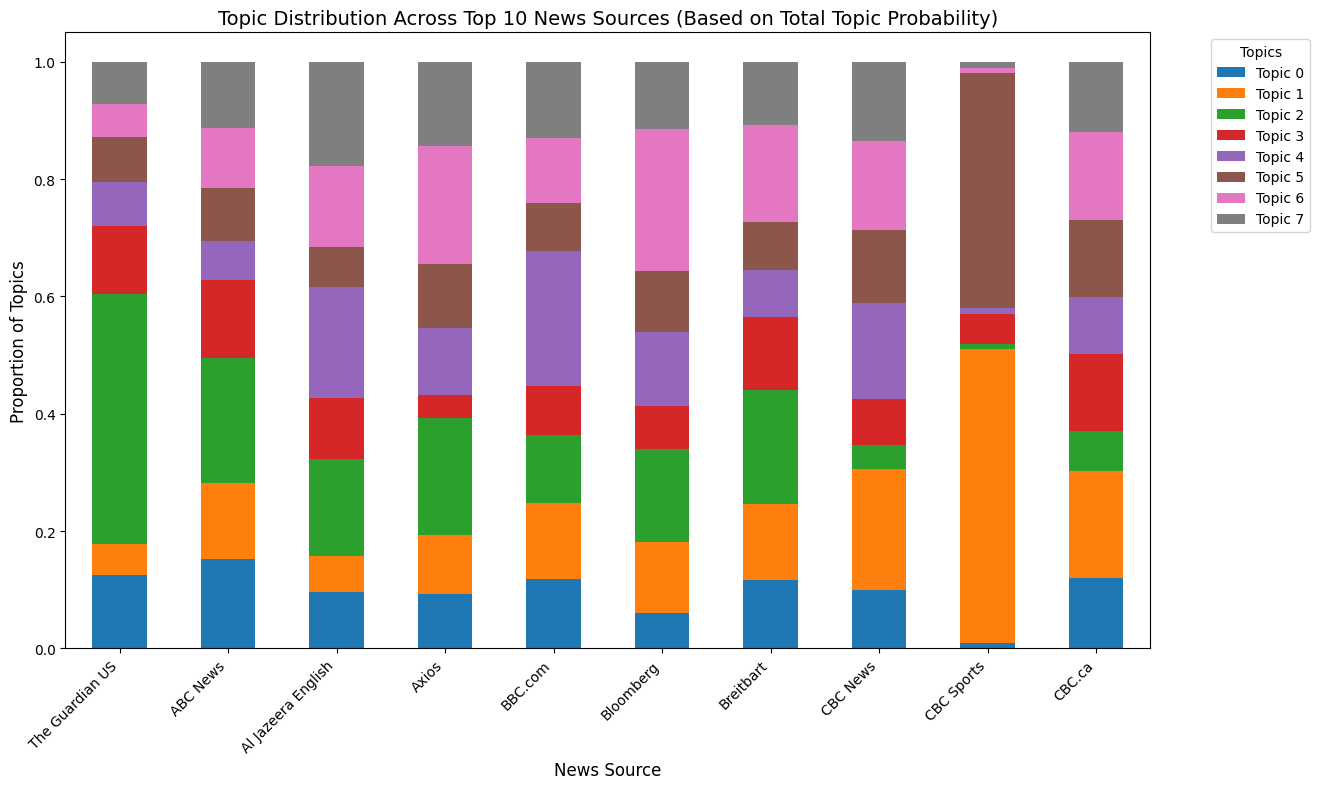

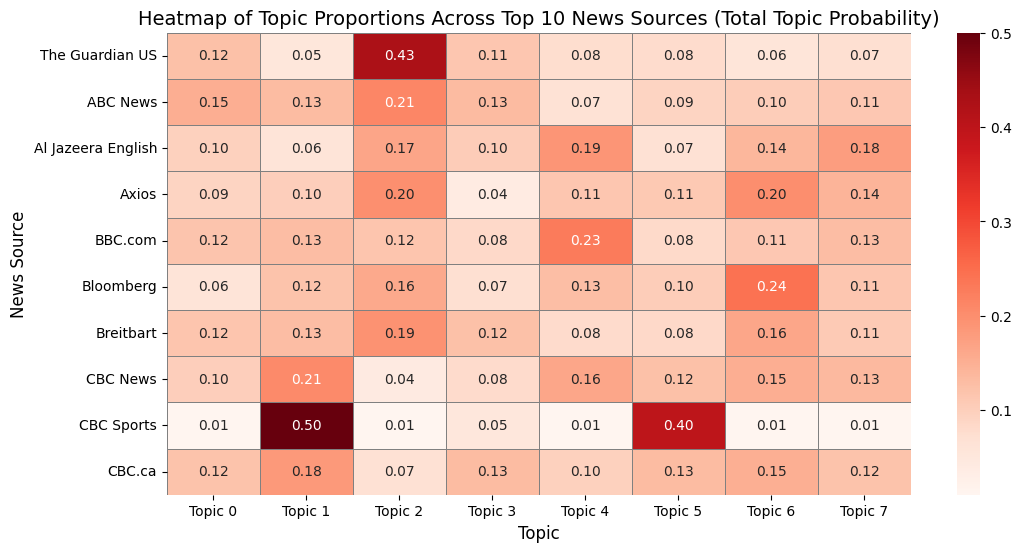

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get topic distribution per document
def get_topic_distribution(lda_model, corpus):
    topic_distributions = []
    for doc_bow in corpus:
        topic_probs = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        topic_vector = [prob for _, prob in topic_probs]
        topic_distributions.append(topic_vector)
    return np.array(topic_distributions)

# Compute topic distribution for each document
topic_distributions = get_topic_distribution(lda_model, corpus)

# Convert to DataFrame
topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic {i}" for i in range(num_topics)])
topic_df["outlet"] = df["outlet"]  # Add news source information

# Aggregate topic probabilities per outlet
outlet_topic_distribution = topic_df.groupby("outlet").mean()

# Select top 10 news sources based on total topic probability
top_outlets = outlet_topic_distribution.sum(axis=1).nlargest(10).index
filtered_distribution = outlet_topic_distribution.loc[top_outlets]

# Normalize topic proportions (percentage-based)
filtered_distribution = filtered_distribution.div(filtered_distribution.sum(axis=1), axis=0)

# Option 1: Improved Stacked Bar Chart with Better Colors
plt.figure(figsize=(14, 8))
color_palette = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78"
]  # Manually selected visually distinct and aesthetically pleasing colors

ax = filtered_distribution.plot(kind="bar", stacked=True, figsize=(14, 8), color=color_palette)

plt.title("Topic Distribution Across Top 10 News Sources (Based on Total Topic Probability)", fontsize=14)
plt.xlabel("News Source", fontsize=12)
plt.ylabel("Proportion of Topics", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# Option 2: Improved Heatmap with "Reds" Colormap
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_distribution, cmap="Reds", annot=True, fmt=".2f", linewidths=0.5, linecolor="gray")

plt.title("Heatmap of Topic Proportions Across Top 10 News Sources (Total Topic Probability)", fontsize=14)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("News Source", fontsize=12)
plt.show()
